# Déploiement d'un modèle avancé sur Azure ML

In [1]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

# importation des librairies nécessaires 
from azureml.core import Workspace, Run, Model, Webservice, Environment
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
import json, requests

from PIL import Image
import base64
from io import BytesIO

import segmentation_models as sm
import cv2
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


### Récupération de la configuration du meilleur modèle

In [2]:
# Le fichier config est téléchargé à partir de Azure
ws = Workspace.from_config(path='./', _file_name='config.json')

In [3]:
# Ici on utilise l'identifiant du run (Run ID) du meilleur modèle qui est
# visible sur le tableau de bord Azure
run = Run.get(
    ws, 'backbone_augmentation_1624916987_9d1b4458')
# Récupération des métriques du meilleur modèle
metrics = run.get_metrics()

### Enregistrement de la configuration du modèle

In [4]:
# Utilisation des métriques du meilleur modèle, demander à l'enregistrer dans outputs, nom, etc
model = run.register_model( model_path ='outputs',
                    model_name = 'efficientnetb7_diceloss_augmentation',
                    properties = {"Val iou score" : max(metrics['val_iou_score'])}  )

In [5]:
# Affichage de certains détails du modèle enregistré (nom, id et version)
print(model.name, model.id, model.version, sep='\t')

efficientnetb7_diceloss_augmentation	efficientnetb7_diceloss_augmentation:10	10


### Création de l'environnement pour le déploiement

In [6]:
# Réutiliser le même modèle que les expériences mais avec CPU au lieu de GPU
env_list = Environment.list(workspace=ws)
env_selected = env_list['AzureML-TensorFlow-2.3-CPU'].clone('TensorFlow-2.3-CPU')
#env_selected

In [7]:
env_selected.docker.enabled = True
#docker_config = DockerConfiguration(use_docker=True)


conda_dep = env_selected.python.conda_dependencies

conda_dep.add_conda_package('pip')
conda_dep.add_conda_package('pandas')
conda_dep.add_conda_package('numpy')
conda_dep.add_conda_package('scikit-learn')
conda_dep.add_conda_package('matplotlib')
conda_dep.remove_pip_package('horovod')
conda_dep.remove_pip_package('cmake')
conda_dep.add_conda_package('tensorflow')
conda_dep.add_conda_package('keras')
conda_dep.add_conda_package('IPython')
conda_dep.add_conda_package('nltk')
conda_dep.add_pip_package("albumentations")
#conda_dep.add_pip_package("cityscapesscripts")
conda_dep.add_pip_package("segmentation-models")
#conda_dep.add_pip_package("opencv-python")
conda_dep.add_pip_package('opencv-python-headless')#('cv2')
conda_dep.add_pip_package("pillow==5.4.1")

env_selected.python
env_selected.python.conda_dependencies = conda_dep

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


In [ ]:
#env_selected

### Configuration du modèle à déployer

In [8]:
# Indication de l'emplacement du script qui fait le traitement des sentiments
# et l'environnement
inference_config = InferenceConfig(
    entry_script="./scripts/predict.py", environment=env_selected)
# Lors de la création du webservice, indication qu'on va utiliser
# une machine cpu à 3 coreS et de 15GB de mémoire. Ici ce n'est plus nécessaire d'utiliser le GPU
deployment_config = AciWebservice.deploy_configuration(
    cpu_cores=3, memory_gb=15)

In [9]:
# Donner un nom au service d'analyse de sentiment
service_name = "service-segmentation-voiture"
# Indiquer les
service = Model.deploy(ws, service_name, Model.list(
    ws, 'efficientnetb7_diceloss_augmentation'), inference_config, deployment_config)
#service = Model.deploy(ws, service_name, [model_name], inference_config, deployment_config)
service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-07-16 16:11:13+02:00 Creating Container Registry if not exists.
2021-07-16 16:11:14+02:00 Registering the environment.
2021-07-16 16:11:15+02:00 Use the existing image.
2021-07-16 16:11:16+02:00 Generating deployment configuration.
2021-07-16 16:11:17+02:00 Submitting deployment to compute..
2021-07-16 16:11:23+02:00 Checking the status of deployment service-segmentation-voiture..
2021-07-16 16:14:50+02:00 Checking the status of inference endpoint service-segmentation-voiture.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [ ]:
#print(service.get_logs())

### Test du déploiement

In [10]:
services = Webservice.list(ws)
print(services[0].scoring_uri)
print(services[0].swagger_uri)

http://4c568a7f-267d-4cac-b079-94dbdb4f76a3.westeurope.azurecontainer.io/score
http://4c568a7f-267d-4cac-b079-94dbdb4f76a3.westeurope.azurecontainer.io/swagger.json


In [11]:
id_image = "munster_000096_000019"
j_img_  = "./preprocessed/val/" + id_image +"_leftImg8bit.png"
j_mask_ = "./preprocessed/val/" + id_image +"_gtFine_labelIds.png"

## Réalisation de test de l'API du modèle sur mesure avancé

In [12]:
img = Image.open(j_img_)

#Convertir l'image d'oreiller en octets, puis en base64
buffered = BytesIO()
img.save(buffered, format="PNG")
img_byte = buffered.getvalue() # bytes
img_base64 = base64.b64encode(img_byte) #octets encodés en base64 * pas str

#C'est toujours des octets si json.Convertir en str en vidages(Parce que l'élément json ne prend pas en charge le type d'octets)
img_str = img_base64.decode('utf-8') # str

files = {
    "text":"envoi",
    "img":img_str
    }

In [13]:
input_data = json.dumps(files)

# Set the content type
headers = {'Content-Type': 'application/json', 'Cache-Control': 'no-cache'}

# Make the request and display the response
resp = requests.post(services[0].scoring_uri, input_data, headers=headers)#POST sur le serveur en tant que json

#print(resp.json())

#json.loads(resp.json())
#d["text"]


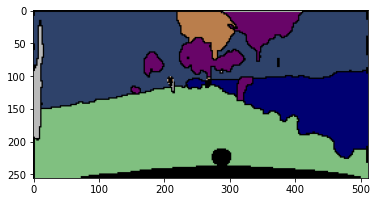

In [14]:
mask = json.loads(resp.json())["img"]
def convert_reception(img):
    #Obtenir l'image
    img = base64.b64decode(img) #Convertir les données d'image converties en base64 en données binaires d'origine# bytes
    img = BytesIO(img) # _io.Converti pour être géré par l'oreiller BytesIO
    return img
mask = convert_reception(mask)
mask = np.array(Image.open(mask))
plt.imshow(mask)

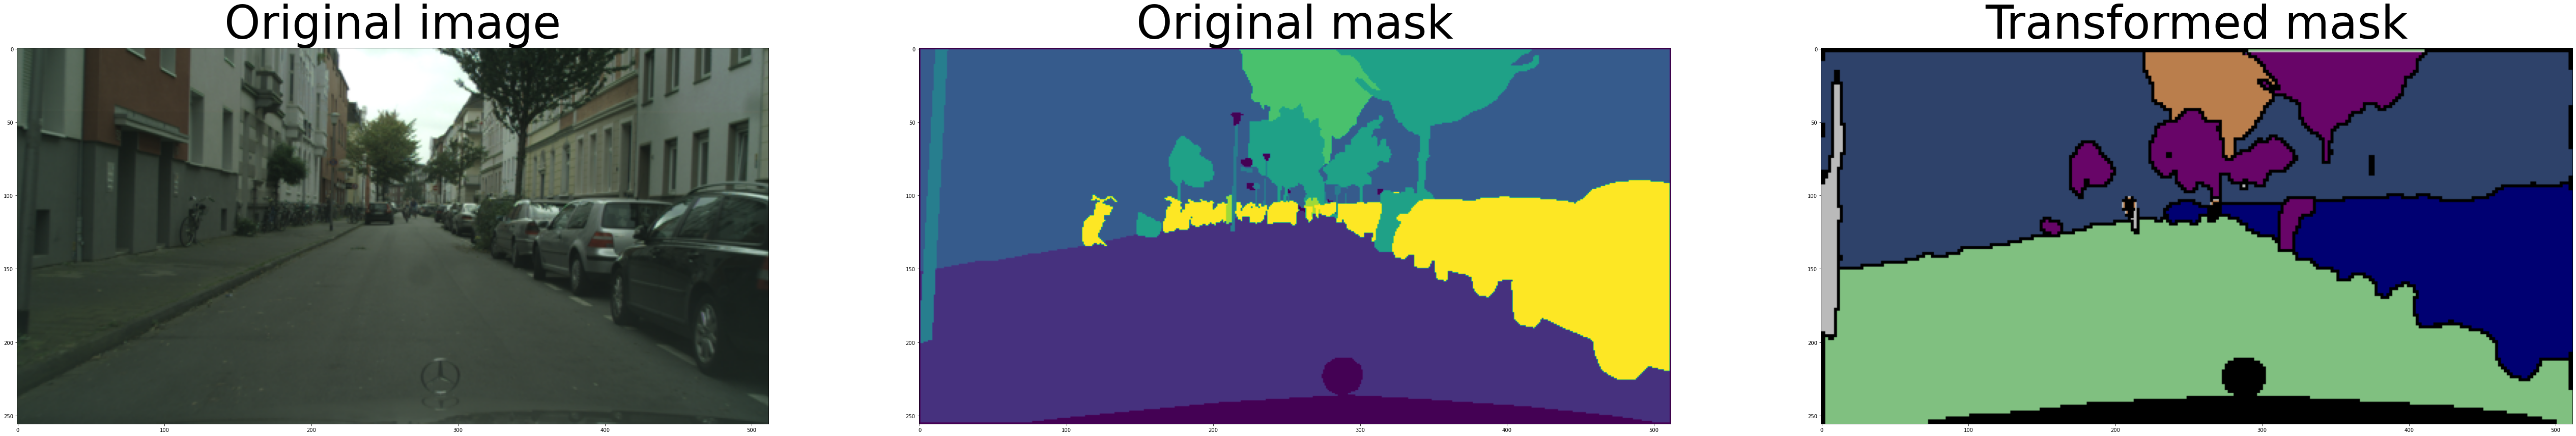

In [15]:
img = Image.open(j_img_)
mask_=Image.open(j_mask_)
def visualize( mask, original_image=None, original_mask=None):
    fontsize = 90

    fig, ax = plt.subplots(1, 3, figsize=(90, 90))


    ax[0].imshow(original_image)
    ax[0].set_title('Original image', fontsize=fontsize)

    ax[1].imshow(original_mask)
    ax[1].set_title('Original mask', fontsize=fontsize)

    ax[2].imshow(mask)
    ax[2].set_title('Transformed mask', fontsize=fontsize)
#predicted_mask = cv2.resize(mask.astype(np.float32), (512, 256))
def cat2color(arr_to_convert):
    prediction_color = {0: (0,0,0), # void - background   "#1D507A"
                        1: (128,64,128), #flat - road  "#2F6999"
                        2:  (210, 190, 150), #(180,165,180), #construction  "#66A0D1"
                        3: (70,70,70), #object - poteau "#8FC0E9"
                        4: (152,251,152), #nature - vegetation "#4682B4"
                        5: (70,130,180), #sky  "#7f7f7f"
                        6: (255,0,0), #human  "#bcbd22"
                        7: (0,0,142) } #vehicle   "#9467bd"
    arr = np.zeros((*arr_to_convert.shape, 3))
    for k, v in prediction_color.items():
        arr[arr_to_convert == k] = v
    arr = arr.astype('uint8')
    return arr

visualize( mask, img , mask_)

In [ ]:
%%writefile ./scripts/predict.py

import json
import pickle
import os



from numpy import argmax
import base64
from io import BytesIO


from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from azureml.core import Workspace, Run



from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf


import albumentations as A
#%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import segmentation_models as sm

import numpy as np

def init():
    """ La fonction init() va initialiser le service API au début, cette partie 
    ne sera pas exécutée à chaque fois il y a une nouvelle requête"""
    # Création de variables globales
    global model
    #global tokenizer

    # Indication du chemin du modèle
    model_path = os.getenv('AZUREML_MODEL_DIR')

    # Définition de l'architecture
    
    input_size=(128, 256, 3)
    BACKBONE = 'efficientnetb7' #BACKBONE = 'efficientnetb3' #BACKBONE = 'resnet34'
    # define network parameters
    n_classes = 8
    activation = 'softmax'
    #create model
    sm.set_framework('tf.keras')
    model = sm.Unet(BACKBONE,input_size, classes=n_classes, activation=activation)
    model.load_weights(model_path + '/outputs/unet.hdf5')


def pretraitement(original_j_img):
    j_img = np.array(original_j_img) / 255
    resize = A.Resize(height=128, width=256, p=1)
    rcz = resize(image=j_img)
    msk = rcz['image']
    return msk



def cat2color(arr_to_convert):
    prediction_color = {0: (0,0,0), # void - background   "#1D507A"
                        1: (128,64,128), #flat - road  "#2F6999"
                        2:  (210, 190, 150), #(180,165,180), #construction  "#66A0D1"
                        3: (70,70,70), #object - poteau "#8FC0E9"
                        4: (152,251,152), #nature - vegetation "#4682B4"
                        5: (70,130,180), #sky  "#7f7f7f"
                        6: (255,0,0), #human  "#bcbd22"
                        7: (0,0,142) } #vehicle   "#9467bd"
    arr = np.zeros((*arr_to_convert.shape, 3))
    for k, v in prediction_color.items():
        arr[arr_to_convert == k] = v
    arr = arr.astype('uint8')
    return arr
    
def predict(msk):
    
    """Fonction qui va faire la segmenttion des images"""
       
    # Faire la prédiction
    val_preds = model.predict(np.expand_dims(msk, axis=0))  
    val_preds = np.squeeze(val_preds, axis=0)
    _mask = np.argmax(val_preds, axis=-1)
    predicted_mask = cv2.resize(_mask.astype(np.float32), (512, 256))
    # Vérification des couleurs
    pred = cat2color(predicted_mask)
    return pred


def convert_reception_flask(json_data):
    #Obtenir le json POSTÉ
    dict_data = json.loads(json_data) #Convertir json en dictionnaire

    img = dict_data["img"] #Sortez base64# str
    img = base64.b64decode(img) #Convertir les données d'image converties en base64 en données binaires d'origine# bytes
    img = BytesIO(img) # _io.Converti pour être géré par l'oreiller BytesIO
    return img

def convert_reception(img):
    #Obtenir l'image
    img = base64.b64decode(img) #Convertir les données d'image converties en base64 en données binaires d'origine# bytes
    img = BytesIO(img) # _io.Converti pour être géré par l'oreiller BytesIO
    return img

def convert_emission(img):
    #Convertir l'image d'oreiller en octets, puis en base64
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    img_byte = buffered.getvalue() # bytes
    img_base64 = base64.b64encode(img_byte) #octets encodés en base64 * pas str
    #C'est toujours des octets si json.Convertir en str en vidages(Parce que l'élément json ne prend pas en charge le type d'octets)
    img_str = img_base64.decode('utf-8') # str
    return img_str

    
def run(raw_data):
    """ Fonction appelée lors de l'appel à l'API à chaque nouvelle requête
    Dans cette fonction il y a récupération des données, application de la tockenisation,
    et le padding puis prédiction afin de décoder le sentiment"""
    try:
        
 
        #    Traitement pour récupérer l'image   #Obtenir le json POSTÉ
        json_data = json.loads(raw_data)["img"]
        img = convert_reception(json_data)
        img = Image.open(img) 
        

        #________faire les prétraitements pour images        
        msk = pretraitement(img)
        pred = predict(msk)
        
        # Rajouter ce traitement suite à la modification des couleurs d epixels
        pred = Image.fromarray((pred * 255).astype(np.uint8))

        img_str = convert_emission(pred)   #img_str = convert_emission(img)    

        
        
        #Renvoyer le résultat du traitement au client
        response  = {
            "text":"reponse- zeineb",
            "img":img_str #img_shape 
            }
        
        return json.dumps(response)#return json.dumps(preds) #return jsonify(response)



    except Exception as e:
        error = str(e)
        return error
